In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function for one-hot encoding
def encode_one_hot(labels):
    num_samples = labels.shape[0]
    num_classes = 10  # Assuming 10 classes (0-9)
    encoded = np.zeros((num_samples, num_classes), dtype=int)
    encoded[np.arange(num_samples), labels] = 1
    return encoded

# Function to read pixel data
def load_pixel_data(file_path):
    with open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 784).astype('float32') / 255.0

# Function to read label data
def load_label_data(file_path):
    with open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return encode_one_hot(labels)

# Function to load MNIST dataset
def load_data(base_path):
    X_train = load_pixel_data(os.path.join(base_path, "train-images-idx3-ubyte"))
    y_train = load_label_data(os.path.join(base_path, "train-labels-idx1-ubyte"))
    X_test = load_pixel_data(os.path.join(base_path, "t10k-images-idx3-ubyte"))
    y_test = load_label_data(os.path.join(base_path, "t10k-labels-idx1-ubyte"))
    return X_train, y_train, X_test, y_test

# Logistic Regression Model
class LogisticModel:
    def __init__(self, lr=5e-4, reg=1e-4, num_epochs=100, batch=200, input_size=784, num_classes=10, init_type='normal'):
        self.lr = lr
        self.reg = reg
        self.epochs = num_epochs
        self.batch_size = batch
        if init_type == 'normal':
            self.weights = np.random.normal(0, 1, (input_size, num_classes))  # N(0, 1)
        elif init_type == 'uniform':
            limit = np.sqrt(6 / (input_size + num_classes))
            self.weights = np.random.uniform(-limit, limit, (input_size, num_classes))
        elif init_type == 'zero':
            self.weights = np.zeros((input_size, num_classes))
        else:
            raise ValueError("Unsupported weight initialization type")
        self.biases = np.zeros((1, num_classes))

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Numerical stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples = X_train.shape[0]
        for epoch in range(self.epochs):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, self.batch_size):
                end = start + self.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.biases
                predictions = self.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / self.batch_size + self.reg * self.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / self.batch_size

                # Update weights and biases
                self.weights -= self.lr * grad_weights
                self.biases -= self.lr * grad_biases

            val_accuracy, _ = self.evaluate(X_val, y_val)
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.biases
        return np.argmax(self.softmax(logits), axis=1)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        y_true_labels = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_true_labels == y_pred)
        return accuracy, self.conf_matrix(y_true_labels, y_pred)

    @staticmethod
    def conf_matrix(y_true, y_pred):
        num_classes = np.max(y_true) + 1
        cm = np.zeros((num_classes, num_classes), dtype=int)
        for true_label, pred_label in zip(y_true, y_pred):
            cm[true_label, pred_label] += 1
        return cm

# Plot confusion matrix
def plot_matrix(matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Experiment with batch sizes
def batch_size_experiment(X_train, y_train, X_val, y_val, params):
    batch_sizes = [1000, 6000, 8000]  # Experiment with different batch sizes
    results = {}
    
    for batch in batch_sizes:
        print(f"\nBatch Size Experiment: {batch}")
        
        # Update the batch size in the params dictionary
        params_with_batch = {**params, 'batch': batch}
        model = LogisticModel(**params_with_batch)
        
        # Train the model and collect accuracies per epoch
        accuracies = []
        num_samples = X_train.shape[0]

        for epoch in range(params['num_epochs']):
            indices = np.random.permutation(num_samples)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, batch):
                end = start + batch
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass and backpropagation
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / batch + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / batch

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            # Evaluate on validation set after each epoch
            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{params['num_epochs']}, Batch Size: {batch}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Store the list of accuracies for the current batch size
        results[batch] = accuracies

    # Plot validation accuracy vs. epochs for all batch sizes
    plot_accuracies(results)


# Plot validation accuracies
def plot_accuracies(results):
    plt.figure(figsize=(10, 6))
    for key, values in results.items():
        plt.plot(range(1, len(values) + 1), values, label=key)
    plt.title("Validation Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Weight Initialization Experiment
def weight_initialization_experiment(X_train, y_train, X_val, y_val, params):
    init_types = ['zero', 'uniform', 'normal']
    results = {}

    for init_type in init_types:
        print(f"\nWeight Initialization Experiment: {init_type.capitalize()}")
        params_with_init = {**params, 'init_type': init_type}
        model = LogisticModel(**params_with_init)
        accuracies = []

        for epoch in range(model.epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, X_train.shape[0], model.batch_size):
                end = start + model.batch_size
                X_batch, y_batch = X_train[start:end], y_train[start:end]

                # Forward pass
                logits = np.dot(X_batch, model.weights) + model.biases
                predictions = model.softmax(logits)

                # Gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / model.batch_size + model.reg * model.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / model.batch_size

                # Update weights and biases
                model.weights -= model.lr * grad_weights
                model.biases -= model.lr * grad_biases

            val_accuracy, _ = model.evaluate(X_val, y_val)
            accuracies.append(val_accuracy)
            print(f"Epoch {epoch + 1}/{model.epochs}, {init_type.capitalize()} Initialization, Validation Accuracy: {val_accuracy:.4f}")

        results[f"{init_type.capitalize()} Initialization"] = accuracies

    plot_accuracies(results)

# Train the default model for Question 2.1
def train_default_model(X_train, y_train, X_test, y_test, params):
    print("Training the Default Model...")
    model = LogisticModel(**params)
    model.train(X_train, y_train, X_test, y_test)
    test_accuracy, cm = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    class_labels = [f"Class {i}" for i in range(10)]
    plot_matrix(cm, class_labels)


dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/mnist"
X_train, y_train, X_test, y_test = load_data(dataset_path)
X_val, y_val = X_train[:10000], y_train[:10000]
X_train, y_train = X_train[10000:], y_train[10000:]

params = {
    'lr': 5e-4,
    'reg': 1e-4,
    'num_epochs': 100,
    'batch': 200,
    'input_size': 784,
    'num_classes': 10
}

Training the Default Model...
Epoch 1/100, Validation Accuracy: 0.1043
Epoch 2/100, Validation Accuracy: 0.1131
Epoch 3/100, Validation Accuracy: 0.1163
Epoch 4/100, Validation Accuracy: 0.1208
Epoch 5/100, Validation Accuracy: 0.1271
Epoch 6/100, Validation Accuracy: 0.1334
Epoch 7/100, Validation Accuracy: 0.1391
Epoch 8/100, Validation Accuracy: 0.1447
Epoch 9/100, Validation Accuracy: 0.1499
Epoch 10/100, Validation Accuracy: 0.1541
Epoch 11/100, Validation Accuracy: 0.1601
Epoch 12/100, Validation Accuracy: 0.1678
Epoch 13/100, Validation Accuracy: 0.1751
Epoch 14/100, Validation Accuracy: 0.1848
Epoch 15/100, Validation Accuracy: 0.1958
Epoch 16/100, Validation Accuracy: 0.2060
Epoch 17/100, Validation Accuracy: 0.2161
Epoch 18/100, Validation Accuracy: 0.2245
Epoch 19/100, Validation Accuracy: 0.2339
Epoch 20/100, Validation Accuracy: 0.2406
Epoch 21/100, Validation Accuracy: 0.2483
Epoch 22/100, Validation Accuracy: 0.2547
Epoch 23/100, Validation Accuracy: 0.2615
Epoch 24/100,

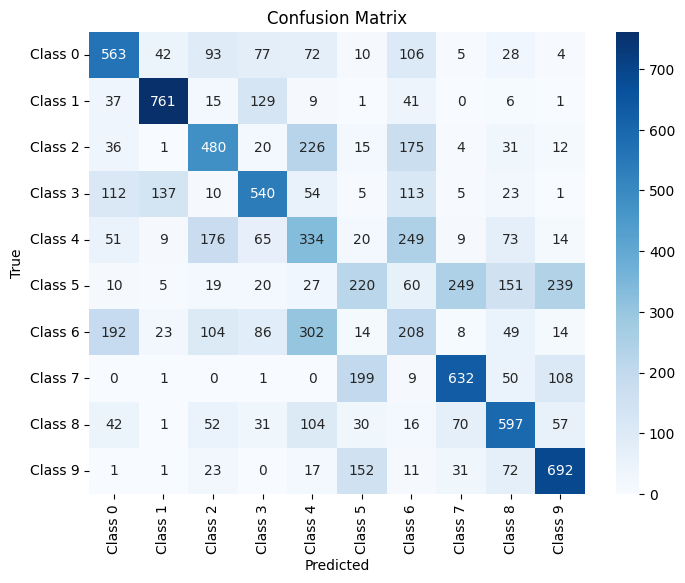

In [3]:
train_default_model(X_train, y_train, X_test, y_test, params)

In [ ]:
batch_size_experiment(X_train, y_train, X_val, y_val, params)

In [ ]:
weight_initialization_experiment(X_train, y_train, X_val, y_val, params)